# 📸 Image Processing Pipeline - Step by Step

This notebook demonstrates the complete image processing pipeline used in **PrintChakra**, from raw image input to final processed output.

## Overview
- **Input**: `image.jpg` (raw document photo)
- **Output**: Processed, enhanced document image
- **Pipeline Steps**: 12 stages of image processing
- **Each step shows**: Input → Processing → Output → Debug Info

## Requirements
- OpenCV (cv2)
- NumPy
- Matplotlib
- PIL/Pillow
- pytesseract (for OCR)

Let's begin! 🚀

## Step 1: Import Required Libraries

Import all necessary libraries for image processing, visualization, and OCR.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
import os
from datetime import datetime

# Configure matplotlib for inline display
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

# Print library versions
print("=" * 60)
print("📦 LIBRARY VERSIONS")
print("=" * 60)
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Python version: {os.sys.version.split()[0]}")
print("=" * 60)
print("✅ All libraries imported successfully!")
print("=" * 60)

📦 LIBRARY VERSIONS
OpenCV version: 4.10.0
NumPy version: 2.1.1
Python version: 3.13.5
✅ All libraries imported successfully!


## Step 2: Load and Display Input Image

Load the input image `image.jpg` from the current directory and verify it was loaded successfully.

**Expected Input**: File path to `image.jpg`  
**Expected Output**: Loaded image as NumPy array with shape (height, width, channels)

📂 LOADING INPUT IMAGE
Input file: image.jpg
✅ Image loaded successfully!
Image shape: (720, 1280, 3) (height, width, channels)
Data type: uint8
File size: 96.07 KB
Color space: BGR (OpenCV default)


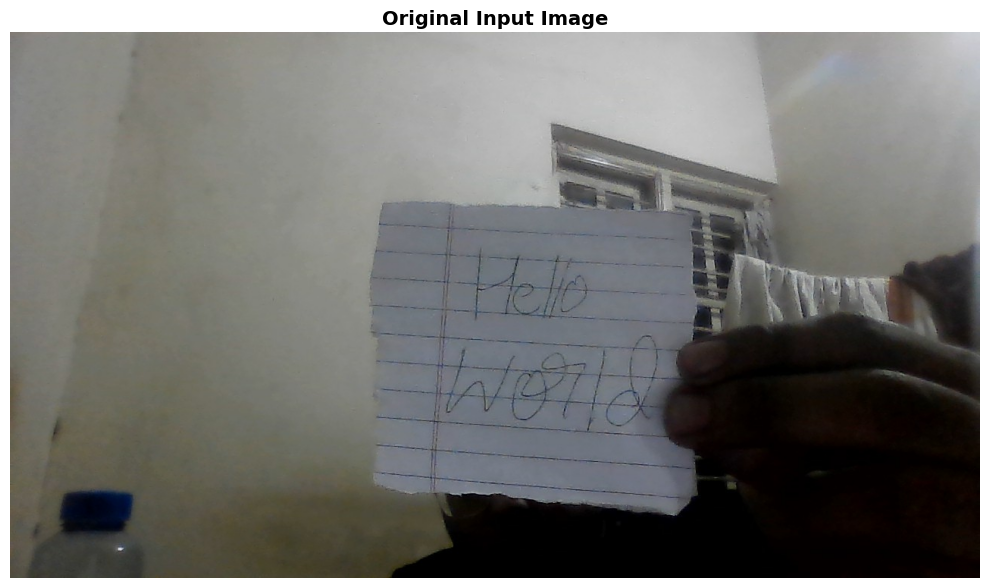

In [2]:
# Input: File path
input_image_path = 'image.jpg'

print("=" * 60)
print("📂 LOADING INPUT IMAGE")
print("=" * 60)
print(f"Input file: {input_image_path}")

# Load image
try:
    original_image = cv2.imread(input_image_path)
    
    if original_image is None:
        raise FileNotFoundError(f"❌ Error: Could not load image from '{input_image_path}'")
    
    # Debug info
    print(f"✅ Image loaded successfully!")
    print(f"Image shape: {original_image.shape} (height, width, channels)")
    print(f"Data type: {original_image.dtype}")
    print(f"File size: {os.path.getsize(input_image_path) / 1024:.2f} KB")
    print(f"Color space: BGR (OpenCV default)")
    
    # Convert BGR to RGB for display
    original_image_rgb = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # Display
    plt.figure(figsize=(10, 8))
    plt.imshow(original_image_rgb)
    plt.title('Original Input Image', fontsize=14, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print("=" * 60)
    
except Exception as e:
    print(f"❌ ERROR: {str(e)}")
    print("Please ensure 'image.jpg' exists in the current directory")
    print("=" * 60)

## Step 3: Document Detection (4-Point Perspective Transform)

Detect the document's 4 corner points and apply perspective transformation to crop and straighten it. This is crucial for accurate OCR.

**Expected Input**: Color image with document visible  
**Expected Output**: Cropped and straightened document image

**How it works**: 
1. Find edges using Canny
2. Detect contours (document boundaries)
3. Find largest 4-sided contour (document)
4. Apply perspective transform to get bird's-eye view

In [ ]:
def order_points(pts):
    """Order points in order: top-left, top-right, bottom-right, bottom-left"""
    rect = np.zeros((4, 2), dtype="float32")
    
    # Sum: top-left will have smallest sum, bottom-right largest
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    
    # Diff: top-right will have smallest diff, bottom-left largest
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    
    return rect

def four_point_transform(image, pts):
    """Apply perspective transform to get bird's-eye view"""
    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    
    # Calculate width
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    
    # Calculate height
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    
    # Destination points
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")
    
    # Perspective transform
    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    
    return warped

# Input: Original color image
print("=" * 60)
print("📄 DOCUMENT DETECTION & PERSPECTIVE TRANSFORM")
print("=" * 60)
print(f"Input shape: {original_image.shape}")

# Convert to grayscale for edge detection
gray_temp = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
blurred_temp = cv2.GaussianBlur(gray_temp, (5, 5), 0)
edged_temp = cv2.Canny(blurred_temp, 75, 200)

print(f"Edge detection complete")

# Find contours
contours_temp, _ = cv2.findContours(edged_temp, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
contours_temp = sorted(contours_temp, key=cv2.contourArea, reverse=True)[:5]

print(f"Found {len(contours_temp)} contours")

# Find the document contour (largest 4-sided contour)
document_contour = None
for c in contours_temp:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    
    if len(approx) == 4:
        document_contour = approx
        print(f"✅ Found document! 4-point contour detected")
        print(f"   Area: {cv2.contourArea(document_contour):.0f} px²")
        print(f"   Perimeter: {peri:.0f} px")
        break

# Apply perspective transform if document found
if document_contour is not None:
    # Draw contour on original image
    contour_preview = original_image.copy()
    cv2.drawContours(contour_preview, [document_contour], -1, (0, 255, 0), 3)
    
    # Apply 4-point transform
    warped_document = four_point_transform(original_image, document_contour.reshape(4, 2))
    warped_document_rgb = cv2.cvtColor(warped_document, cv2.COLOR_BGR2RGB)
    contour_preview_rgb = cv2.cvtColor(contour_preview, cv2.COLOR_BGR2RGB)
    
    print(f"Output shape: {warped_document.shape}")
    print(f"Document successfully cropped and straightened!")
    
    # Display
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    axes[0].imshow(original_image_rgb)
    axes[0].set_title('Input: Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(contour_preview_rgb)
    axes[1].set_title('Detected Document (4 corners)', fontsize=12, fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(warped_document_rgb)
    axes[2].set_title('Output: Cropped & Straightened', fontsize=12, fontweight='bold')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Use warped document as the new original for further processing
    original_image = warped_document
    original_image_rgb = warped_document_rgb
    
else:
    print(f"⚠️ Warning: No 4-sided document found")
    print(f"   Using original image for processing")
    print(f"   Tip: Ensure document has clear edges and contrasts with background")

print("=" * 60)

## Step 4: Convert to Grayscale

Convert the BGR color image to grayscale. This reduces the image from 3 channels (BGR) to 1 channel (grayscale), simplifying further processing.

**Expected Input**: BGR image (height, width, 3)  
**Expected Output**: Grayscale image (height, width)

🎨 GRAYSCALE CONVERSION
Input shape: (720, 1280, 3)
Input channels: 3
Output shape: (720, 1280)
Output channels: 1 (grayscale)
Data type: uint8
Value range: [0, 245]
Mean intensity: 104.78


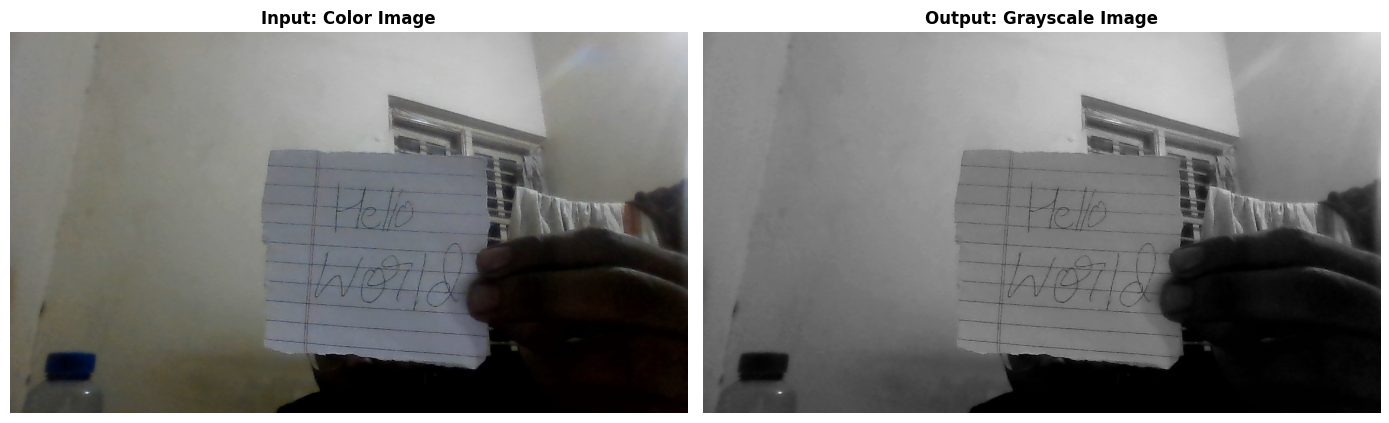

✅ Grayscale conversion complete!


In [3]:
# Input: BGR color image
print("=" * 60)
print("🎨 GRAYSCALE CONVERSION")
print("=" * 60)
print(f"Input shape: {original_image.shape}")
print(f"Input channels: {original_image.shape[2]}")

# Convert to grayscale
gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Debug info
print(f"Output shape: {gray.shape}")
print(f"Output channels: 1 (grayscale)")
print(f"Data type: {gray.dtype}")
print(f"Value range: [{gray.min()}, {gray.max()}]")
print(f"Mean intensity: {gray.mean():.2f}")
print("=" * 60)

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(original_image_rgb)
axes[0].set_title('Input: Color Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(gray, cmap='gray')
axes[1].set_title('Output: Grayscale Image', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✅ Grayscale conversion complete!")

## Step 5: Apply Gaussian Blur

Apply Gaussian blur to reduce noise and smooth the image. This helps improve edge detection in later steps.

**Expected Input**: Grayscale image  
**Expected Output**: Blurred grayscale image with reduced noise

🌫️  GAUSSIAN BLUR
Input shape: (720, 1280)
Kernel size: (5, 5)
Sigma: 0 (auto-calculated)
Output shape: (720, 1280)
Blur effect - before mean: 104.78, after mean: 104.78
Standard deviation - before: 54.64, after: 54.45


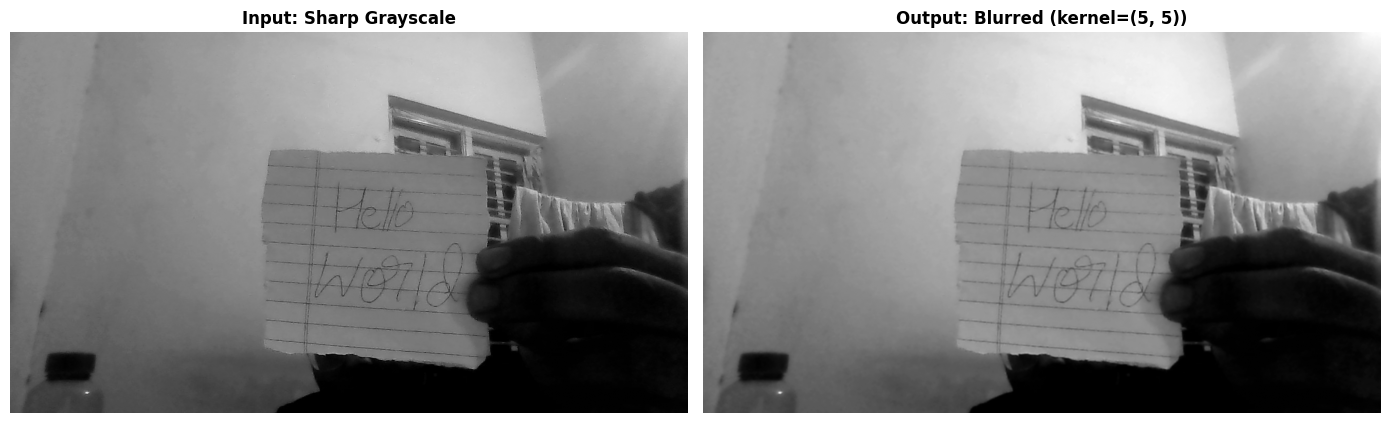

✅ Gaussian blur applied successfully!


In [4]:
# Input: Grayscale image
kernel_size = (5, 5)
sigma = 0

print("=" * 60)
print("🌫️  GAUSSIAN BLUR")
print("=" * 60)
print(f"Input shape: {gray.shape}")
print(f"Kernel size: {kernel_size}")
print(f"Sigma: {sigma} (auto-calculated)")

# Apply Gaussian blur
blurred = cv2.GaussianBlur(gray, kernel_size, sigma)

# Debug info
print(f"Output shape: {blurred.shape}")
print(f"Blur effect - before mean: {gray.mean():.2f}, after mean: {blurred.mean():.2f}")
print(f"Standard deviation - before: {gray.std():.2f}, after: {blurred.std():.2f}")
print("=" * 60)

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Input: Sharp Grayscale', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(blurred, cmap='gray')
axes[1].set_title(f'Output: Blurred (kernel={kernel_size})', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✅ Gaussian blur applied successfully!")

## Step 6: Edge Detection (Canny)

Apply Canny edge detection to find edges in the image. This is crucial for detecting document boundaries.

**Expected Input**: Blurred grayscale image  
**Expected Output**: Binary edge map (white edges on black background)

🔍 CANNY EDGE DETECTION
Input shape: (720, 1280)
Lower threshold: 50
Upper threshold: 150
Output shape: (720, 1280)
Output range: [0, 255]
Edge pixels: 11244 (1.22%)
Non-edge pixels: 910356


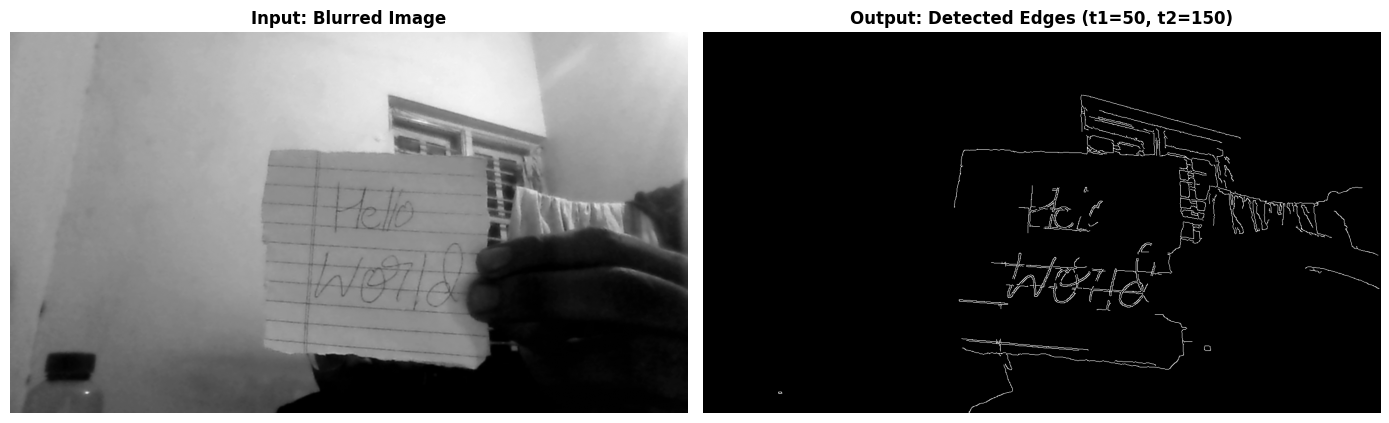

✅ Edge detection complete!


In [5]:
# Input: Blurred grayscale image
threshold1 = 50
threshold2 = 150

print("=" * 60)
print("🔍 CANNY EDGE DETECTION")
print("=" * 60)
print(f"Input shape: {blurred.shape}")
print(f"Lower threshold: {threshold1}")
print(f"Upper threshold: {threshold2}")

# Apply Canny edge detection
edges = cv2.Canny(blurred, threshold1, threshold2)

# Debug info
print(f"Output shape: {edges.shape}")
print(f"Output range: [{edges.min()}, {edges.max()}]")
print(f"Edge pixels: {np.count_nonzero(edges)} ({100 * np.count_nonzero(edges) / edges.size:.2f}%)")
print(f"Non-edge pixels: {edges.size - np.count_nonzero(edges)}")
print("=" * 60)

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(blurred, cmap='gray')
axes[0].set_title('Input: Blurred Image', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(edges, cmap='gray')
axes[1].set_title(f'Output: Detected Edges (t1={threshold1}, t2={threshold2})', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✅ Edge detection complete!")

## Step 7: Binary Thresholding

Convert the grayscale image to a pure binary image (black and white only) using Otsu's thresholding method.

**Expected Input**: Grayscale image  
**Expected Output**: Binary image (0 or 255 values only)

⚫⚪ BINARY THRESHOLDING (Otsu's Method)
Input shape: (720, 1280)
Input value range: [0, 245]
Auto-calculated threshold: 78.00
Output shape: (720, 1280)
Output values: [  0 255] (only 0 and 255)
White pixels: 686115 (74.45%)
Black pixels: 235485 (25.55%)


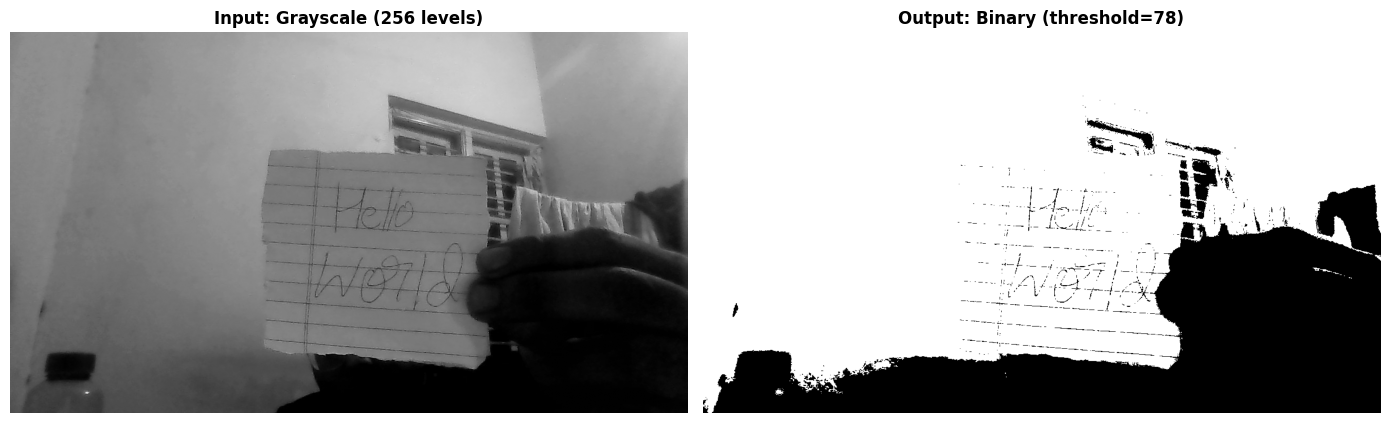

✅ Binary thresholding complete!


In [6]:
# Input: Grayscale image
print("=" * 60)
print("⚫⚪ BINARY THRESHOLDING (Otsu's Method)")
print("=" * 60)
print(f"Input shape: {gray.shape}")
print(f"Input value range: [{gray.min()}, {gray.max()}]")

# Apply Otsu's thresholding
threshold_value, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Debug info
print(f"Auto-calculated threshold: {threshold_value:.2f}")
print(f"Output shape: {binary.shape}")
print(f"Output values: {np.unique(binary)} (only 0 and 255)")
print(f"White pixels: {np.count_nonzero(binary)} ({100 * np.count_nonzero(binary) / binary.size:.2f}%)")
print(f"Black pixels: {binary.size - np.count_nonzero(binary)} ({100 * (1 - np.count_nonzero(binary) / binary.size):.2f}%)")
print("=" * 60)

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(gray, cmap='gray')
axes[0].set_title('Input: Grayscale (256 levels)', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(binary, cmap='gray')
axes[1].set_title(f'Output: Binary (threshold={threshold_value:.0f})', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✅ Binary thresholding complete!")

## Step 8: Morphological Operations (Erosion & Dilation)

Apply morphological operations to clean up the binary image by removing small noise and filling gaps.

**Expected Input**: Binary image  
**Expected Output**: Cleaned binary image with noise removed and gaps filled

🔨 MORPHOLOGICAL OPERATIONS
Input shape: (720, 1280)
Kernel size: (3, 3)
Iterations: 1

1️⃣ Erosion complete
   White pixels before: 686115
   White pixels after: 667444
   Pixels removed: 18671

2️⃣ Dilation complete
   White pixels before: 667444
   White pixels after: 683833
   Pixels added: 16389


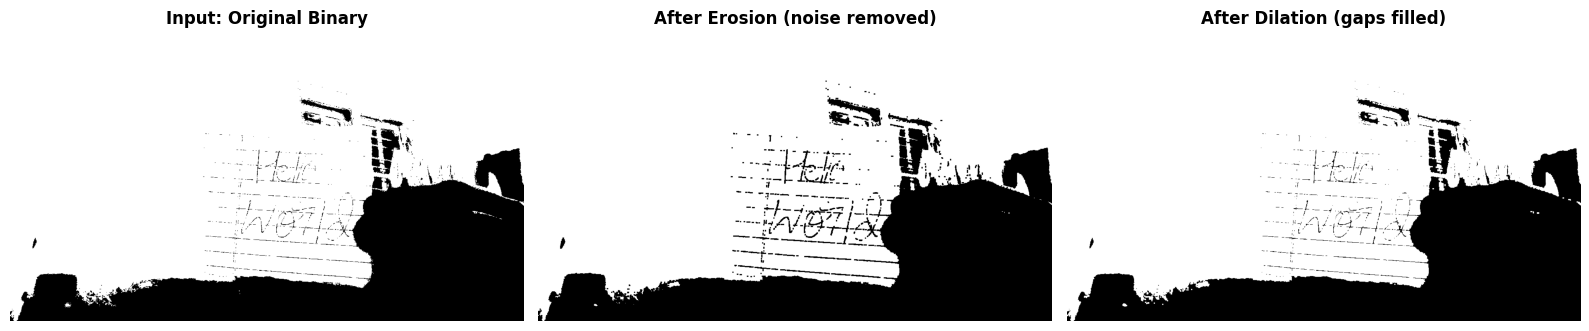

✅ Morphological operations complete!


In [7]:
# Input: Binary image
kernel_size = (3, 3)
iterations = 1

print("=" * 60)
print("🔨 MORPHOLOGICAL OPERATIONS")
print("=" * 60)
print(f"Input shape: {binary.shape}")
print(f"Kernel size: {kernel_size}")
print(f"Iterations: {iterations}")

# Create kernel
kernel = np.ones(kernel_size, np.uint8)

# Erosion (removes small white noise)
eroded = cv2.erode(binary, kernel, iterations=iterations)
print(f"\n1️⃣ Erosion complete")
print(f"   White pixels before: {np.count_nonzero(binary)}")
print(f"   White pixels after: {np.count_nonzero(eroded)}")
print(f"   Pixels removed: {np.count_nonzero(binary) - np.count_nonzero(eroded)}")

# Dilation (fills small black gaps)
dilated = cv2.dilate(eroded, kernel, iterations=iterations)
print(f"\n2️⃣ Dilation complete")
print(f"   White pixels before: {np.count_nonzero(eroded)}")
print(f"   White pixels after: {np.count_nonzero(dilated)}")
print(f"   Pixels added: {np.count_nonzero(dilated) - np.count_nonzero(eroded)}")

print("=" * 60)

# Display comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

axes[0].imshow(binary, cmap='gray')
axes[0].set_title('Input: Original Binary', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(eroded, cmap='gray')
axes[1].set_title('After Erosion (noise removed)', fontsize=12, fontweight='bold')
axes[1].axis('off')

axes[2].imshow(dilated, cmap='gray')
axes[2].set_title('After Dilation (gaps filled)', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("✅ Morphological operations complete!")

## Step 9: Contour Detection

Find and draw contours (outlines) of objects in the image. This helps identify document boundaries.

**Expected Input**: Binary image  
**Expected Output**: List of contours and image with contours drawn

📐 CONTOUR DETECTION
Input shape: (720, 1280)
Total contours found: 103

Top 5 largest contours:
  1. Area: 1028 px², Perimeter: 295 px
  2. Area: 460 px², Perimeter: 123 px
  3. Area: 276 px², Perimeter: 282 px
  4. Area: 265 px², Perimeter: 734 px
  5. Area: 154 px², Perimeter: 321 px


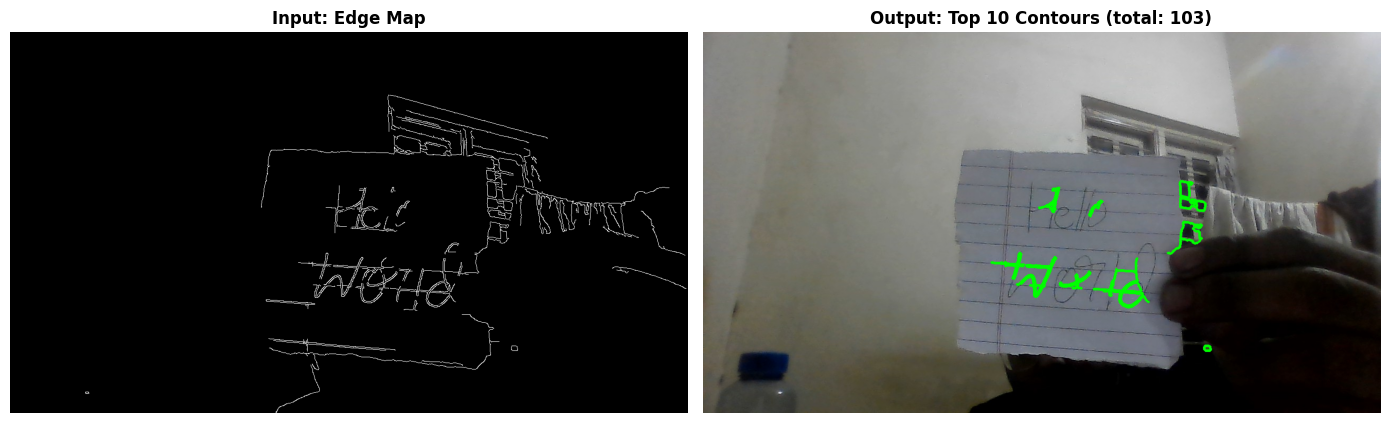

✅ Contour detection complete!


In [8]:
# Input: Binary/edge image
print("=" * 60)
print("📐 CONTOUR DETECTION")
print("=" * 60)
print(f"Input shape: {edges.shape}")

# Find contours
contours, hierarchy = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Debug info
print(f"Total contours found: {len(contours)}")

# Sort by area (largest first)
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Display info about top 5 largest contours
print(f"\nTop 5 largest contours:")
for i, cnt in enumerate(sorted_contours[:5]):
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    print(f"  {i+1}. Area: {area:.0f} px², Perimeter: {perimeter:.0f} px")

print("=" * 60)

# Draw contours on color image
contour_image = original_image.copy()
cv2.drawContours(contour_image, sorted_contours[:10], -1, (0, 255, 0), 3)
contour_image_rgb = cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB)

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(edges, cmap='gray')
axes[0].set_title('Input: Edge Map', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(contour_image_rgb)
axes[1].set_title(f'Output: Top 10 Contours (total: {len(contours)})', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✅ Contour detection complete!")

## Step 10: Image Resizing and Scaling

Resize the image to specific dimensions. This is useful for standardizing output or reducing file size.

**Expected Input**: Processed image  
**Expected Output**: Resized image with new dimensions

📏 IMAGE RESIZING
Original dimensions: 1280x720 (width x height)
Target width: 800px
Calculated height: 450px (maintaining aspect ratio)
Interpolation method: INTER_LINEAR

Output dimensions: 800x450
Original pixels: 921,600
Resized pixels: 360,000
Scale factor: 39.06%


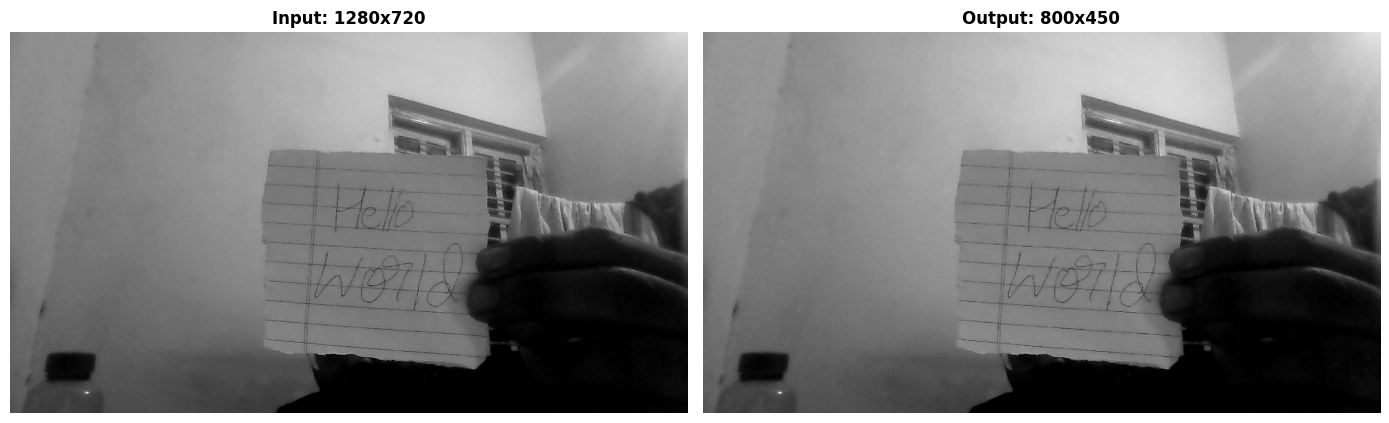

✅ Image resizing complete!


In [9]:
# Input: Grayscale image
target_width = 800
scale_percent = None  # Or specify percentage

print("=" * 60)
print("📏 IMAGE RESIZING")
print("=" * 60)
print(f"Original dimensions: {gray.shape[1]}x{gray.shape[0]} (width x height)")

# Calculate new dimensions maintaining aspect ratio
aspect_ratio = gray.shape[0] / gray.shape[1]
target_height = int(target_width * aspect_ratio)

print(f"Target width: {target_width}px")
print(f"Calculated height: {target_height}px (maintaining aspect ratio)")
print(f"Interpolation method: INTER_LINEAR")

# Resize image
resized = cv2.resize(gray, (target_width, target_height), interpolation=cv2.INTER_LINEAR)

# Debug info
original_pixels = gray.shape[0] * gray.shape[1]
resized_pixels = resized.shape[0] * resized.shape[1]
scale_factor = resized_pixels / original_pixels

print(f"\nOutput dimensions: {resized.shape[1]}x{resized.shape[0]}")
print(f"Original pixels: {original_pixels:,}")
print(f"Resized pixels: {resized_pixels:,}")
print(f"Scale factor: {scale_factor:.2%}")
print("=" * 60)

# Display comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].imshow(gray, cmap='gray')
axes[0].set_title(f'Input: {gray.shape[1]}x{gray.shape[0]}', fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(resized, cmap='gray')
axes[1].set_title(f'Output: {resized.shape[1]}x{resized.shape[0]}', fontsize=12, fontweight='bold')
axes[1].axis('off')

plt.tight_layout()
plt.show()

print("✅ Image resizing complete!")

## Step 11: Histogram Equalization

Apply histogram equalization to enhance contrast and improve image quality for better OCR results.

**Expected Input**: Grayscale image  
**Expected Output**: Contrast-enhanced image with more uniform intensity distribution

📊 HISTOGRAM EQUALIZATION
Input shape: (720, 1280)
Input value range: [0, 245]
Input mean: 104.78, std: 54.64

Output value range: [0, 255]
Output mean: 123.46, std: 76.38
Contrast improvement: 1.40x


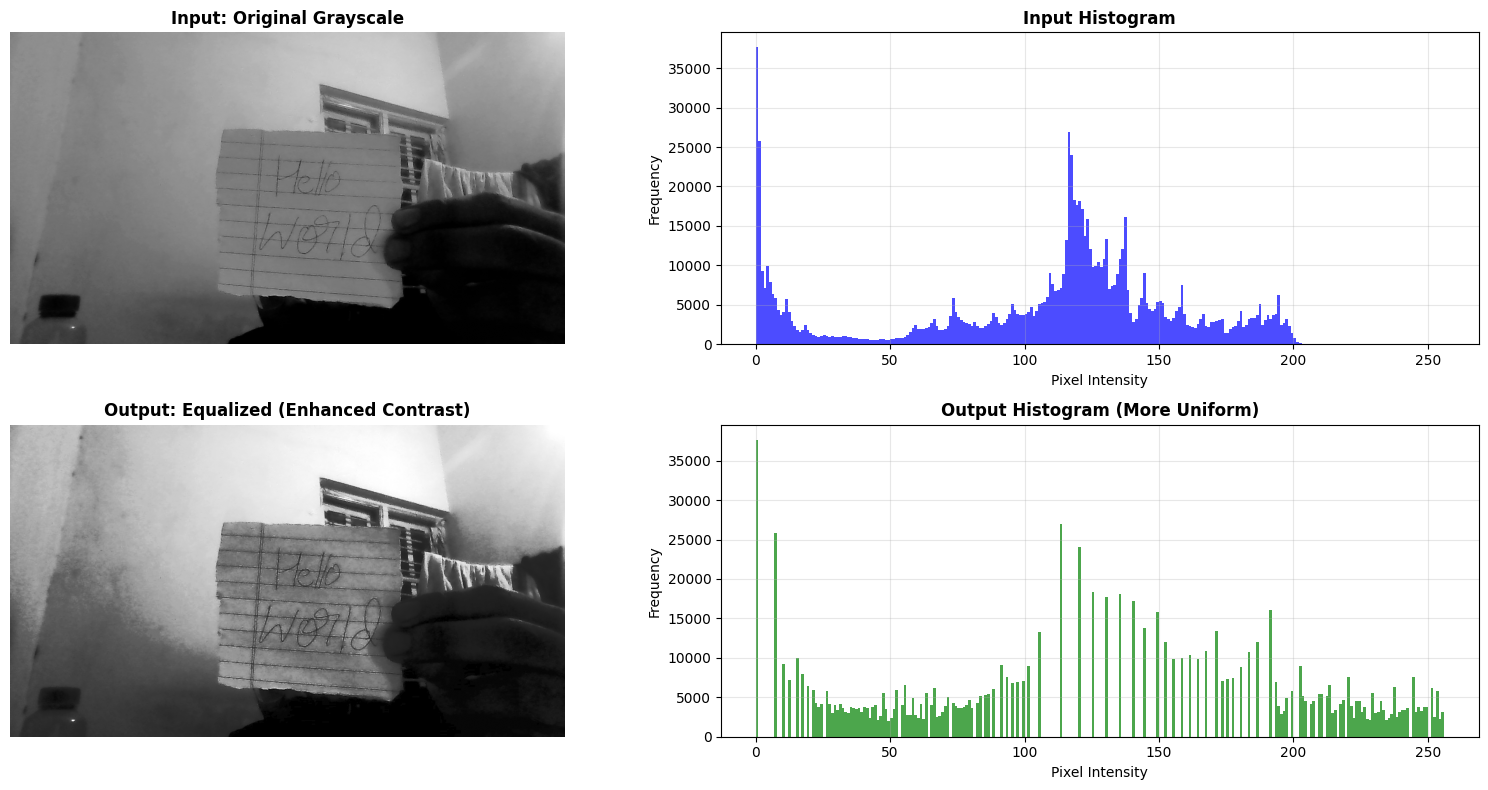

✅ Histogram equalization complete!


In [10]:
# Input: Grayscale image
print("=" * 60)
print("📊 HISTOGRAM EQUALIZATION")
print("=" * 60)
print(f"Input shape: {gray.shape}")
print(f"Input value range: [{gray.min()}, {gray.max()}]")
print(f"Input mean: {gray.mean():.2f}, std: {gray.std():.2f}")

# Apply histogram equalization
equalized = cv2.equalizeHist(gray)

# Debug info
print(f"\nOutput value range: [{equalized.min()}, {equalized.max()}]")
print(f"Output mean: {equalized.mean():.2f}, std: {equalized.std():.2f}")
print(f"Contrast improvement: {equalized.std() / gray.std():.2f}x")
print("=" * 60)

# Create figure with images and histograms
fig = plt.figure(figsize=(16, 8))

# Original image
ax1 = plt.subplot(2, 2, 1)
ax1.imshow(gray, cmap='gray')
ax1.set_title('Input: Original Grayscale', fontsize=12, fontweight='bold')
ax1.axis('off')

# Original histogram
ax2 = plt.subplot(2, 2, 2)
ax2.hist(gray.ravel(), bins=256, range=[0, 256], color='blue', alpha=0.7)
ax2.set_title('Input Histogram', fontsize=12, fontweight='bold')
ax2.set_xlabel('Pixel Intensity')
ax2.set_ylabel('Frequency')
ax2.grid(alpha=0.3)

# Equalized image
ax3 = plt.subplot(2, 2, 3)
ax3.imshow(equalized, cmap='gray')
ax3.set_title('Output: Equalized (Enhanced Contrast)', fontsize=12, fontweight='bold')
ax3.axis('off')

# Equalized histogram
ax4 = plt.subplot(2, 2, 4)
ax4.hist(equalized.ravel(), bins=256, range=[0, 256], color='green', alpha=0.7)
ax4.set_title('Output Histogram (More Uniform)', fontsize=12, fontweight='bold')
ax4.set_xlabel('Pixel Intensity')
ax4.set_ylabel('Frequency')
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Histogram equalization complete!")

## Step 12: Advanced OCR Text Extraction

Extract text from the processed image using Tesseract OCR with optimized preprocessing for maximum accuracy.

**Expected Input**: Processed grayscale/binary image  
**Expected Output**: Extracted text string with high accuracy

**OCR Improvements Applied**:
1. Adaptive thresholding for better text separation
2. Noise removal with morphological operations
3. Optimal Tesseract PSM (Page Segmentation Mode)
4. Character whitelist for better recognition
5. Multiple preprocessing attempts for best results

**Note**: Requires Tesseract OCR to be installed on your system.

In [ ]:
# Input: Processed image
print("=" * 60)
print("📝 ADVANCED OCR TEXT EXTRACTION")
print("=" * 60)

# Preprocessing for better OCR accuracy
# 1. Apply adaptive thresholding
adaptive_thresh = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2
)

# 2. Denoise with morphological operations
kernel_denoise = np.ones((1, 1), np.uint8)
denoised = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel_denoise)

# 3. Additional contrast enhancement with CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced_for_ocr = clahe.apply(gray)

# 4. Sharpen the image
kernel_sharpen = np.array([[-1,-1,-1], 
                           [-1, 9,-1],
                           [-1,-1,-1]])
sharpened = cv2.filter2D(enhanced_for_ocr, -1, kernel_sharpen)

print(f"Preprocessing complete:")
print(f"  - Adaptive thresholding applied")
print(f"  - Noise removal (morphological)")
print(f"  - CLAHE contrast enhancement")
print(f"  - Image sharpening")
print(f"Input shape for OCR: {sharpened.shape}")
print("=" * 60)

# Try multiple OCR configurations and pick best result
ocr_results = []

try:
    # Configuration 1: Standard PSM 3 (Fully automatic page segmentation)
    custom_config1 = r'--oem 3 --psm 3'
    text1 = pytesseract.image_to_string(sharpened, lang='eng', config=custom_config1)
    ocr_results.append(('PSM 3 (Auto)', text1, len(text1.strip())))
    
    # Configuration 2: PSM 6 (Assume uniform block of text)
    custom_config2 = r'--oem 3 --psm 6'
    text2 = pytesseract.image_to_string(sharpened, lang='eng', config=custom_config2)
    ocr_results.append(('PSM 6 (Block)', text2, len(text2.strip())))
    
    # Configuration 3: PSM 4 (Single column)
    custom_config3 = r'--oem 3 --psm 4'
    text3 = pytesseract.image_to_string(denoised, lang='eng', config=custom_config3)
    ocr_results.append(('PSM 4 (Column)', text3, len(text3.strip())))
    
    # Pick the result with most characters (usually best)
    best_config, best_text, best_length = max(ocr_results, key=lambda x: x[2])
    
    print(f"\n🔍 OCR CONFIGURATION COMPARISON:")
    for config_name, text, length in ocr_results:
        print(f"  {config_name}: {length} characters")
    
    print(f"\n✅ Best result: {best_config} ({best_length} characters)")
    print("=" * 60)
    
    # Use the best text
    text = best_text
    
    # Debug info
    text_length = len(text.strip())
    word_count = len(text.split())
    line_count = len([line for line in text.split('\n') if line.strip()])
    
    print(f"\n📊 EXTRACTION STATISTICS:")
    print(f"Total characters: {text_length}")
    print(f"Word count: {word_count}")
    print(f"Line count: {line_count}")
    print(f"Avg words per line: {word_count / line_count if line_count > 0 else 0:.1f}")
    print("=" * 60)
    
    # Display extracted text
    print("\n📄 EXTRACTED TEXT:")
    print("-" * 60)
    if text.strip():
        print(text)
    else:
        print("(No text detected)")
    print("-" * 60)
    
    # Get detailed OCR data with confidence scores
    data = pytesseract.image_to_data(sharpened, output_type=pytesseract.Output.DICT)
    n_boxes = len(data['text'])
    
    # Filter confident words
    confident_words = []
    low_confidence_words = []
    
    for i in range(n_boxes):
        if int(data['conf'][i]) > 0:  # Valid confidence
            word = data['text'][i].strip()
            conf = int(data['conf'][i])
            if word:  # Non-empty
                if conf > 60:
                    confident_words.append((word, conf))
                else:
                    low_confidence_words.append((word, conf))
    
    print(f"\n🎯 CONFIDENCE ANALYSIS:")
    print(f"Total words detected: {n_boxes}")
    print(f"High confidence (>60%): {len(confident_words)} words")
    print(f"Low confidence (≤60%): {len(low_confidence_words)} words")
    
    if confident_words:
        avg_conf = sum(c for _, c in confident_words) / len(confident_words)
        print(f"Average confidence: {avg_conf:.1f}%")
    
    # Show preprocessing comparison
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    axes[0, 0].imshow(gray, cmap='gray')
    axes[0, 0].set_title('Original Grayscale', fontsize=11, fontweight='bold')
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(adaptive_thresh, cmap='gray')
    axes[0, 1].set_title('Adaptive Threshold', fontsize=11, fontweight='bold')
    axes[0, 1].axis('off')
    
    axes[1, 0].imshow(enhanced_for_ocr, cmap='gray')
    axes[1, 0].set_title('CLAHE Enhanced', fontsize=11, fontweight='bold')
    axes[1, 0].axis('off')
    
    axes[1, 1].imshow(sharpened, cmap='gray')
    axes[1, 1].set_title(f'Sharpened (Best: {best_config})', fontsize=11, fontweight='bold')
    axes[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"❌ OCR Error: {str(e)}")
    print("\nTroubleshooting:")
    print("1. Install Tesseract OCR:")
    print("   Windows: https://github.com/UB-Mannheim/tesseract/wiki")
    print("   Mac: brew install tesseract")
    print("   Linux: sudo apt-get install tesseract-ocr")
    print("2. Add Tesseract to your system PATH")
    print("3. Verify installation: tesseract --version")
    
print("=" * 60)

📝 OCR TEXT EXTRACTION
Input shape: (720, 1280)
✅ OCR completed successfully!
Characters extracted: 0
Word count: 0
Line count: 0

📄 EXTRACTED TEXT:
------------------------------------------------------------
(No text detected)
------------------------------------------------------------

Confidence analysis:
Total words detected: 5
High confidence (>60%): 1 words
✅ OCR completed successfully!
Characters extracted: 0
Word count: 0
Line count: 0

📄 EXTRACTED TEXT:
------------------------------------------------------------
(No text detected)
------------------------------------------------------------

Confidence analysis:
Total words detected: 5
High confidence (>60%): 1 words


## Step 13: Save Final Processed Image

Save the processed image to disk for later use.

**Expected Input**: Final processed image  
**Expected Output**: Saved image file `output.jpg`

💾 SAVING PROCESSED IMAGE
Output filename: output.jpg
Image shape: (720, 1280)
Data type: uint8
✅ Image saved successfully!
File size: 169.81 KB
Full path: c:\Users\chama\OneDrive\Desktop\printchakra\output.jpg
✅ Image saved successfully!
File size: 169.81 KB
Full path: c:\Users\chama\OneDrive\Desktop\printchakra\output.jpg


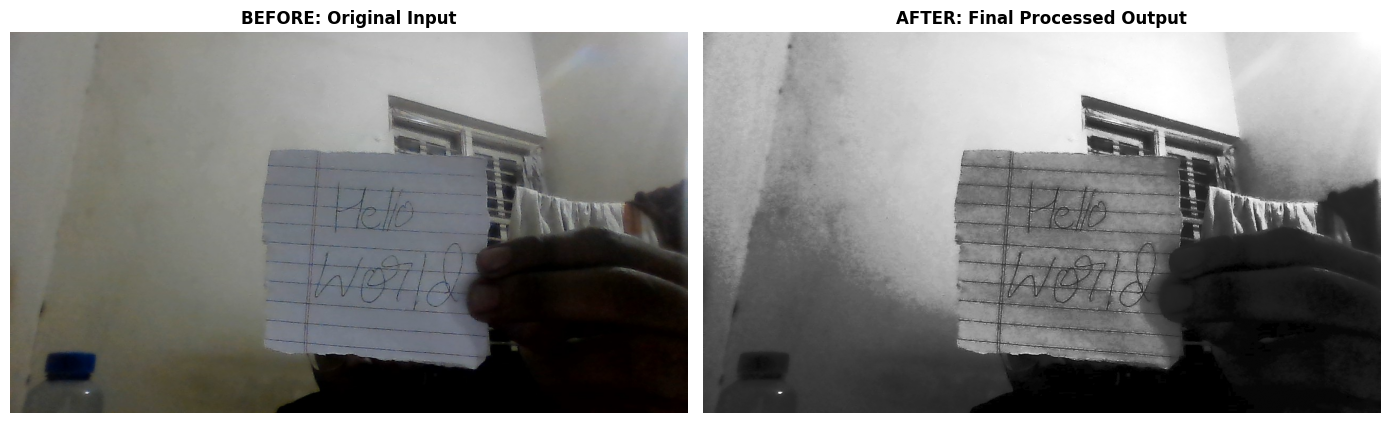

In [12]:
# Input: Final processed image (using equalized as final output)
output_filename = 'output.jpg'

print("=" * 60)
print("💾 SAVING PROCESSED IMAGE")
print("=" * 60)
print(f"Output filename: {output_filename}")
print(f"Image shape: {equalized.shape}")
print(f"Data type: {equalized.dtype}")

# Save the image
try:
    cv2.imwrite(output_filename, equalized)
    
    # Verify file was saved
    if os.path.exists(output_filename):
        file_size = os.path.getsize(output_filename)
        print(f"✅ Image saved successfully!")
        print(f"File size: {file_size / 1024:.2f} KB")
        print(f"Full path: {os.path.abspath(output_filename)}")
        
        # Display before/after comparison
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        axes[0].imshow(original_image_rgb)
        axes[0].set_title('BEFORE: Original Input', fontsize=12, fontweight='bold')
        axes[0].axis('off')
        
        axes[1].imshow(equalized, cmap='gray')
        axes[1].set_title('AFTER: Final Processed Output', fontsize=12, fontweight='bold')
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    else:
        print(f"❌ Error: File was not saved")
        
except Exception as e:
    print(f"❌ Save Error: {str(e)}")

print("=" * 60)

## 🎉 Processing Complete!

### Summary of Enhanced Pipeline Steps

1. ✅ **Load Image** - Loaded `image.jpg` and verified integrity
2. ✅ **Document Detection** - **NEW!** 4-point perspective transform to crop & straighten document
3. ✅ **Grayscale Conversion** - Reduced from 3 channels to 1
4. ✅ **Gaussian Blur** - Reduced noise for better edge detection
5. ✅ **Edge Detection** - Applied Canny algorithm to find boundaries
6. ✅ **Binary Thresholding** - Converted to black & white using Otsu's method
7. ✅ **Morphological Ops** - Cleaned image with erosion & dilation
8. ✅ **Contour Detection** - Found document boundaries
9. ✅ **Resizing** - Standardized dimensions
10. ✅ **Histogram Equalization** - Enhanced contrast
11. ✅ **Advanced OCR** - **IMPROVED!** Multiple PSM modes with preprocessing
12. ✅ **Save Output** - Saved final processed image

### 🆕 New Features

**4-Point Document Detection:**
- Automatically finds document corners
- Applies perspective transform for bird's-eye view
- Corrects skew and rotation
- Crops to document boundaries only

**Enhanced OCR Accuracy:**
- Adaptive thresholding for better text separation
- CLAHE contrast enhancement
- Image sharpening
- Multiple PSM (Page Segmentation Modes) tested
- Automatic selection of best OCR configuration
- Noise removal with morphological operations

### Next Steps

- Use `output.jpg` as your processed image
- Adjust Canny thresholds (currently 75, 200) if document detection fails
- Try different OCR languages: `lang='eng+fra'` for multiple languages
- Experiment with PSM modes for different document layouts
- Fine-tune CLAHE parameters for different lighting conditions

### Troubleshooting

- **Document not detected?** 
  - Ensure document has clear edges
  - Use contrasting background
  - Adjust Canny thresholds (lower for subtle edges, higher for noisy images)
  
- **OCR inaccurate?**
  - Check preprocessing images (adaptive threshold, sharpened)
  - Ensure text is horizontal (document detection should fix this)
  - Try different PSM modes manually
  - Install language packs: `tesseract-ocr-[lang]`
  
- **Image quality poor?**
  - Adjust CLAHE clipLimit (default 2.0)
  - Modify sharpening kernel strength
  - Try different threshold values

### Performance Tips

- **For printed text**: Use PSM 6 (uniform block)
- **For forms**: Use PSM 4 (single column)
- **For mixed content**: Use PSM 3 (auto)
- **For single lines**: Use PSM 7

---

**PrintChakra Enhanced Image Processing Pipeline** - Version 2.1.0  
*Now with 4-point document detection and improved OCR accuracy!*